In [28]:
#! pip install --user opencv-python
#! pip install --user matplotlib
# !pip install --user seaborn
# some dependencies might need to be installed

In [14]:
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import time as t

In [20]:
IMAGE_PATH = './208.jpg'
image = cv2.imread(IMAGE_PATH)

In [21]:
def print_image(image):
    cv_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

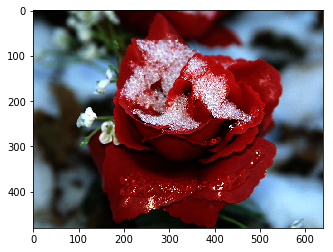

In [22]:
print_image(image)

## Ke Contrast
The constrast is based on the calculation of the HSV histogram of the image.

In [24]:
channels = cv2.split(image)
colors = ('h', 's', 'v')

In [25]:
for (channel, color) in zip(channels, colors):
    if color == 'h':
        histogram = cv2.calcHist([channel], [0], None, [8], [0, 180])
    else:
        histogram = cv2.calcHist([channel], [0], None, [8], [0, 256])

cv2.normalize(histogram, histogram)


array([[ 0.40907979],
       [ 0.42862195],
       [ 0.40772465],
       [ 0.52315146],
       [ 0.37910962],
       [ 0.22434233],
       [ 0.10680018],
       [ 0.05958499]], dtype=float32)